### This notebook is in mypycaret environment to test the models for BigG_express data using the data merged df that were craeted in the previous notebook

In [1]:
#Libraries need for work

import pandas as pd
from datetime import datetime, timedelta



from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

#we need to create a conda environment for pycaret and then pip install the packages after activating and rerun the notebook.
from pycaret.classification import *
from pycaret.regression import *
from pycaret.time_series import *

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [2]:
faults_clean = pd.read_csv("../data/faults_clean.csv")

In [11]:
faults_clean.shape
faults_clean.info()
faults_clean.columns.to_series().groupby(faults_clean.dtypes).groups

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546674 entries, 0 to 546673
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             546674 non-null  int64  
 1   RecordID               546674 non-null  int64  
 2   ESS_Id                 546674 non-null  int64  
 3   EventTimeStamp         546674 non-null  object 
 4   eventDescription       517014 non-null  object 
 5   ecuSoftwareVersion     414247 non-null  object 
 6   ecuSerialNumber        393180 non-null  object 
 7   ecuModel               518571 non-null  object 
 8   ecuMake                518571 non-null  object 
 9   ecuSource              546674 non-null  int64  
 10  spn                    546674 non-null  int64  
 11  fmi                    546674 non-null  int64  
 12  active                 546674 non-null  bool   
 13  activeTransitionCount  546674 non-null  int64  
 14  EquipmentID            546674 non-nu

{bool: ['active'], int64: ['Unnamed: 0', 'RecordID', 'ESS_Id', 'ecuSource', 'spn', 'fmi', 'activeTransitionCount', 'MCTNumber'], float64: ['Latitude', 'Longitude'], object: ['EventTimeStamp', 'eventDescription', 'ecuSoftwareVersion', 'ecuSerialNumber', 'ecuModel', 'ecuMake', 'EquipmentID', 'LocationTimeStamp']}

In [4]:
derate_target = pd.read_pickle('../data/derate_target.pk')

In [8]:
derate_target.shape

(546674, 2)

In [3]:
derate_feature = pd.read_pickle('../data/derate_features.pk')

In [7]:
derate_feature.shape

(546674, 461)

In [13]:
derate_feature.info()
derate_feature.columns.to_series().groupby(derate_feature.dtypes).groups

<class 'pandas.core.frame.DataFrame'>
Int64Index: 546674 entries, 536775 to 70148
Columns: 461 entries, RecordID to target
dtypes: bool(1), datetime64[ns](2), float64(419), int32(1), int64(6), object(32)
memory usage: 1.9+ GB


{bool: ['active'], int64: ['RecordID', 'spn', 'fmi', 'ecuSource', 'spn', 'fmi'], float64: ['Latitude', 'Longitude', 'spn_0', 'spn_100', 'spn_101', 'spn_102', 'spn_1023', 'spn_1024', 'spn_1028', 'spn_103', 'spn_1043', 'spn_1045', 'spn_105', 'spn_1056', 'spn_1059', 'spn_1067', 'spn_1068', 'spn_107', 'spn_1071', 'spn_1072', 'spn_1075', 'spn_1078', 'spn_108', 'spn_1081', 'spn_110', 'spn_111', 'spn_1127', 'spn_114863', 'spn_116', 'spn_1172', 'spn_1176', 'spn_118', 'spn_1209', 'spn_1213', 'spn_1231', 'spn_1235', 'spn_1236', 'spn_1239', 'spn_1247', 'spn_125', 'spn_127', 'spn_1279', 'spn_1321', 'spn_1322', 'spn_1323', 'spn_1324', 'spn_1325', 'spn_1326', 'spn_1327', 'spn_1328', 'spn_1347', 'spn_1349', 'spn_13600', 'spn_139296', 'spn_1464', 'spn_1481', 'spn_1482', 'spn_1483', 'spn_1487', 'spn_153', 'spn_153931', 'spn_1569', 'spn_157', 'spn_158', 'spn_16', 'spn_160', 'spn_1612', 'spn_1659', 'spn_1668', 'spn_167', 'spn_1675', 'spn_168', 'spn_17096', 'spn_171', 'spn_173', 'spn_174', 'spn_175', 'spn

In [5]:
derate_target.shape #(546674, 2)

(546674, 2)

In [6]:
derate_feature.shape #(546674, 461)

(546674, 461)

In [14]:
derate_feature['DistanceLtd'].isna().sum()

0

In [9]:
# derate_feature.columns.to_list()


In [10]:
#how to find a column where a particula string exists
# word = 'Low (Severity Low) Engine Coolant Level' #this string is causing problem which is present in event description so going to drop that column as well
word = 'unknown'
derate_feature.columns[derate_feature[derate_feature==word].notna().sum()>0][0]

'ecuSoftwareVersion'

In [11]:
# X = derate_feature.drop(columns=['EquipmentID_y', 'eventDescription', 'ecuSoftwareVersion', 'active',
#                                  'ecuModel', 'ecuMake', 'activeTransitionCount', 'EquipmentID_x',
#                                  'MCTNumber', 'SPN_FMI', 'EquipmentID_y', 'spn_fmi','EventTimeStamp',
# 'Latitude',
#  'Longitude',
#  'LocationTimeStamp',
#  'SPN_FMI',
#  'target'])

X= derate_feature[['AcceleratorPedal', 'BarometricPressure', 'CruiseControlSetSpeed', 'DistanceLtd', 'EngineCoolantTemperature', 'EngineLoad', 'EngineOilPressure', 'EngineOilTemperature', 'EngineRpm', 'EngineTimeLtd', 'FuelLevel', 'FuelLtd', 'FuelRate', 'FuelTemperature', 'IntakeManifoldTemperature', 
                'LampStatus', 'ServiceDistance', 'Speed', 'SwitchedBatteryVoltage', 'Throttle', 'TurboBoostPressure',]]
y = derate_feature[['target']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321)

# linreg_base = LinearRegression().fit(X_train_sm1, y_train_sm1)# 

# X_train_added2.columns
# X_train_added2.head(10)

In [12]:
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)

(410005, 21)
(136669, 21)
(136669, 1)


In [13]:
from sklearn.impute import SimpleImputer
logReg_scaler = Pipeline(
    steps = [
        ('impute', SimpleImputer()), #fills average of the column if there are NaN missing values
        ('scaler', StandardScaler()),
        ('log_reg', LogisticRegression(C = 0.01)) #started from 0.01, 0,001, 
    ]
).fit(X_train, y_train)

In [14]:
# fit the model on X_test data
logreg1 = logReg_scaler.predict(X_test)

In [15]:
#finding the accuracy score

accuracy_score(y_test, logreg1)

0.9971902918730656

In [16]:
pd.DataFrame({'feature': logReg_scaler['impute'].get_feature_names_out(),
                             'coefficient': logReg_scaler['log_reg'].coef_[0],
             "ex_coefficient": np.exp(logReg_scaler['log_reg'].coef_[0])}).sort_values(by='coefficient')
#every drop in the x-feature affects the predicted probability by the ex_coefficient

,feature,coefficient,ex_coefficient
8,EngineRpm,-0.395508,0.673338
1,BarometricPressure,-0.283382,0.753232
6,EngineOilPressure,-0.242197,0.784902
14,IntakeManifoldTemperature,-0.165102,0.847807
11,FuelLtd,-0.075440,0.927336
10,FuelLevel,-0.055616,0.945902
4,EngineCoolantTemperature,-0.033965,0.966606
0,AcceleratorPedal,-0.018691,0.981482
7,EngineOilTemperature,-0.010503,0.989552
17,Speed,-0.009411,0.990633


In [17]:
confusion_matrix(y_test, logReg_scaler.predict(X_test))

array([[136285,      2],
       [   382,      0]], dtype=int64)

In [18]:
from cm import plot_confusion_matrix #cm is function writen by Michael

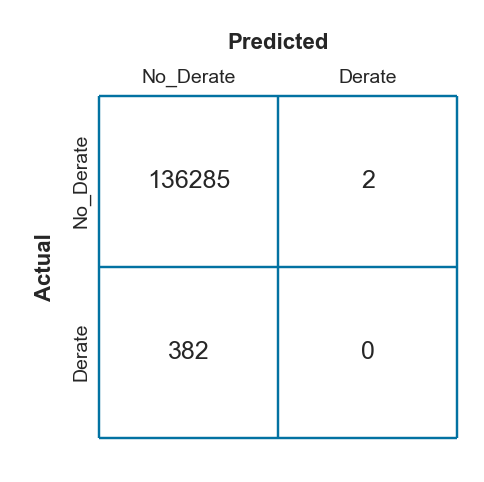

In [19]:
plot_confusion_matrix(y_test, logReg_scaler.predict(X_test), labels = ['No_Derate', 'Derate']);

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

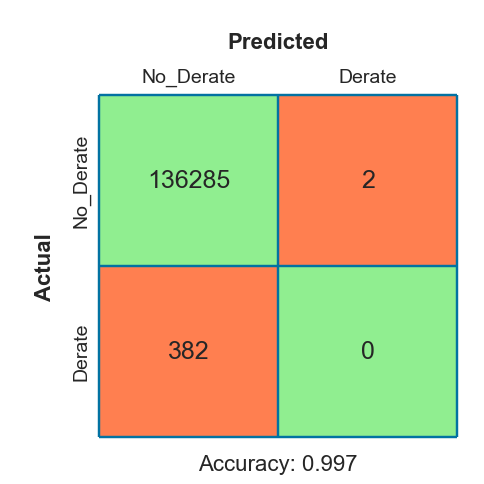

In [21]:
plot_confusion_matrix(y_test, logReg_scaler.predict(X_test), labels = ['No_Derate', 'Derate'], metric = 'accuracy');

In [22]:
from sklearn.metrics import roc_auc_score

In [23]:
roc_auc_score(y_test, logReg_scaler.predict_proba(X_test)[:,1] )

0.8525730675299205

In [36]:
derate_feature['EquipmentID_x'].nunique() #1042
derate_feature.loc[derate_feature['target']==1]['EquipmentID_x'].nunique() #189

#list of the all trucks EquipentID where derate happened
derate_trucks = derate_feature.loc[derate_feature['target']==1]['EquipmentID_x'].unique()

#list of the all trucks EquipentID in faults table
all_trucks = derate_feature['EquipmentID_x'].unique()

#list of the all trucks EquipentID which did not have any derate
no_derate = all_trucks[np.isin(all_trucks, derate_trucks, invert=True)]

len(no_derate) #853
# derate_feature.loc[derate_feature['target']==0]['EquipmentID_x'].nunique()

853

In [25]:
174932+371742

546674

In [37]:
df_derate = derate_feature[(derate_feature['EquipmentID_x'].isin(derate_trucks))]
df_derate.shape #(174932, 461)

(174932, 1443)

In [27]:
df_no = derate_feature[(derate_feature['EquipmentID_x'].isin(no_derate))] #371742 rows × 461 columns

In [28]:
df_derate

,RecordID,spn,fmi,AcceleratorPedal,BarometricPressure,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,...,spn_94,spn_940,spn_941,spn_95,spn_96,spn_97,spn_976,spn_98,spn_fmi,target
444126,1248431,96,3,0.0,14.645,66.48672,443434.9,186.8,12.0,22.62,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,96_3,0
444127,1248432,829,3,0.0,14.645,66.48672,443434.9,186.8,12.0,22.62,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,829_3,0
444128,1248425,829,3,0.0,14.645,66.48672,443434.3,185.0,17.0,22.04,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,829_3,0
444129,1248426,96,3,0.0,14.645,66.48672,443434.3,185.0,17.0,22.04,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,96_3,0
444130,1248394,96,3,0.0,14.645,66.48672,443424.0,185.0,12.0,24.94,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,96_3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157880,17,111,17,37.2,14.1375,66.48672,268575.9,183.2,26.0,33.64,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111_17,0
36118,62,111,17,57.6,14.4275,64.6226,470383.5,190.4,46.0,35.96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111_17,0
126238,11,111,17,0.0,14.1375,64.6226,257885.9,181.4,80.0,34.22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111_17,0
36119,6,111,17,48.0,14.4275,64.6226,470381.4,181.4,30.0,38.28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111_17,0


In [29]:
#Now we will divide in train test trucks with derate or noderate with each truck(EquipmentID) either in train or test not both.

In [30]:
##Making the 80/20 split in the train/test among all the trucks with derate
X = df_derate.drop(columns=['target'])
y= df_derate[['target']]

X_train_derate, X_test_derate, y_train_derate, y_test_derate = train_test_split(X, y, train_size = 0.8,
                                                                                test_size = 0.2, 
                                                                                random_state = 321)

print(X_train_derate.shape)
print(X_test_derate.shape)
print(y_train_derate.shape)
print(y_test_derate.shape)

(139945, 460)
(34987, 460)
(139945, 1)
(34987, 1)


In [31]:
##Making the 80/20 split in the train/test among all the trucks with noderate

X_no = df_no.drop(columns=['target'])
y_no= df_no[['target']]

X_train_noderate, X_test_noderate, y_train_noderate, y_test_noderate = train_test_split(X_no, y_no, train_size = 0.8,
                                                                                test_size = 0.2, 
                                                                                random_state = 321)

print(X_train_noderate.shape)
print(X_test_noderate.shape)
print(y_train_noderate.shape)
print(y_test_noderate.shape)

(297393, 460)
(74349, 460)
(297393, 1)
(74349, 1)


In [32]:
## Putting the derate_train and non_derate_train together like wise doing that with the test
# df = all_trucks[~all_trucks[['EquipmentID']].isin(derate_trucks).any(axis=1)]
# pd.concat([data1, data2], axis=0)

X_train1 = pd.concat([X_train_derate, X_train_noderate], axis=0) #437338 rows × 460 columns

X_test1 = pd.concat([X_test_derate, X_test_noderate], axis=0) #109336 rows × 460 columns

y_train1 = pd.concat([y_train_derate, y_train_noderate], axis=0) #437338 rows × 1 columns

y_test1 = pd.concat([y_test_derate, y_test_noderate], axis=0) #109336 rows × 1 columns

In [33]:
#cases take out due to 25% or more missing values
y_train1['target'].value_counts()

0    436221
1      1117
Name: target, dtype: int64

In [34]:
#cases take out due to 25% or more missing values
y_test1['target'].value_counts()

0    109064
1       272
Name: target, dtype: int64

In [35]:
X_train1.info()
X_train1.columns.to_series().groupby(X_train1.dtypes).groups

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437338 entries, 170963 to 212282
Columns: 460 entries, RecordID to spn_fmi
dtypes: bool(1), datetime64[ns](2), float64(419), int64(6), object(32)
memory usage: 1.5+ GB


{bool: ['active'], int64: ['RecordID', 'spn', 'fmi', 'ecuSource', 'spn', 'fmi'], float64: ['Latitude', 'Longitude', 'spn_0', 'spn_100', 'spn_101', 'spn_102', 'spn_1023', 'spn_1024', 'spn_1028', 'spn_103', 'spn_1043', 'spn_1045', 'spn_105', 'spn_1056', 'spn_1059', 'spn_1067', 'spn_1068', 'spn_107', 'spn_1071', 'spn_1072', 'spn_1075', 'spn_1078', 'spn_108', 'spn_1081', 'spn_110', 'spn_111', 'spn_1127', 'spn_114863', 'spn_116', 'spn_1172', 'spn_1176', 'spn_118', 'spn_1209', 'spn_1213', 'spn_1231', 'spn_1235', 'spn_1236', 'spn_1239', 'spn_1247', 'spn_125', 'spn_127', 'spn_1279', 'spn_1321', 'spn_1322', 'spn_1323', 'spn_1324', 'spn_1325', 'spn_1326', 'spn_1327', 'spn_1328', 'spn_1347', 'spn_1349', 'spn_13600', 'spn_139296', 'spn_1464', 'spn_1481', 'spn_1482', 'spn_1483', 'spn_1487', 'spn_153', 'spn_153931', 'spn_1569', 'spn_157', 'spn_158', 'spn_16', 'spn_160', 'spn_1612', 'spn_1659', 'spn_1668', 'spn_167', 'spn_1675', 'spn_168', 'spn_17096', 'spn_171', 'spn_173', 'spn_174', 'spn_175', 'spn

In [36]:
chosen_cl = ['RecordID', 'spn', 'fmi', 'AcceleratorPedal', 'BarometricPressure', 'CruiseControlSetSpeed', 'DistanceLtd', 
 'EngineCoolantTemperature', 'EngineLoad', 'EngineOilPressure', 'EngineOilTemperature', 'EngineRpm', 
 'EngineTimeLtd', 'FuelLevel', 'FuelLtd', 'FuelRate', 'FuelTemperature', 'IntakeManifoldTemperature',
 'LampStatus', 'ServiceDistance', 'Speed', 'SwitchedBatteryVoltage', 'Throttle', 'TurboBoostPressure',
  'spn_fmi'
]

In [37]:
X_train_derate.columns.to_series().groupby(X_train_derate.dtypes).groups

{bool: ['active'], int64: ['RecordID', 'spn', 'fmi', 'ecuSource', 'spn', 'fmi'], float64: ['Latitude', 'Longitude', 'spn_0', 'spn_100', 'spn_101', 'spn_102', 'spn_1023', 'spn_1024', 'spn_1028', 'spn_103', 'spn_1043', 'spn_1045', 'spn_105', 'spn_1056', 'spn_1059', 'spn_1067', 'spn_1068', 'spn_107', 'spn_1071', 'spn_1072', 'spn_1075', 'spn_1078', 'spn_108', 'spn_1081', 'spn_110', 'spn_111', 'spn_1127', 'spn_114863', 'spn_116', 'spn_1172', 'spn_1176', 'spn_118', 'spn_1209', 'spn_1213', 'spn_1231', 'spn_1235', 'spn_1236', 'spn_1239', 'spn_1247', 'spn_125', 'spn_127', 'spn_1279', 'spn_1321', 'spn_1322', 'spn_1323', 'spn_1324', 'spn_1325', 'spn_1326', 'spn_1327', 'spn_1328', 'spn_1347', 'spn_1349', 'spn_13600', 'spn_139296', 'spn_1464', 'spn_1481', 'spn_1482', 'spn_1483', 'spn_1487', 'spn_153', 'spn_153931', 'spn_1569', 'spn_157', 'spn_158', 'spn_16', 'spn_160', 'spn_1612', 'spn_1659', 'spn_1668', 'spn_167', 'spn_1675', 'spn_168', 'spn_17096', 'spn_171', 'spn_173', 'spn_174', 'spn_175', 'spn

In [38]:
X_train1_short = X_train1[chosen_cl]
X_train1_short.shape #(437338, 28)
X_train1_short.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437338 entries, 170963 to 212282
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   RecordID                   437338 non-null  int64 
 1   spn                        437338 non-null  int64 
 2   spn                        437338 non-null  int64 
 3   fmi                        437338 non-null  int64 
 4   fmi                        437338 non-null  int64 
 5   AcceleratorPedal           417879 non-null  object
 6   BarometricPressure         437338 non-null  object
 7   CruiseControlSetSpeed      428271 non-null  object
 8   DistanceLtd                437338 non-null  object
 9   EngineCoolantTemperature   437338 non-null  object
 10  EngineLoad                 437338 non-null  object
 11  EngineOilPressure          437338 non-null  object
 12  EngineOilTemperature       437338 non-null  object
 13  EngineRpm                  437338 non-n

In [39]:
X_test1_short = X_test1[chosen_cl]
X_test1_short.shape #(109336, 28)

(109336, 27)

In [40]:
from sklearn.preprocessing import OneHotEncoder

#### Running the above logReg_sclaer pipeline with the equipment clustered train test split data
1. X_train1_short
2. X_test1_short
3. y_train1
4. y_test1

In [41]:
y_train1.head()

,target
170963,0
423364,0
419070,0
368390,0
114639,0


In [42]:
#from sklearn.impute import SimpleImputer
#step1
logReg_scaler = Pipeline(
    steps = [
        ('impute', SimpleImputer()), #fills average of the column if there are NaN missing values
        ('scaler', StandardScaler()),
        ('log_reg', LogisticRegression(C = 0.01)) #started from 0.01, 0,001, 
    ]
).fit(X_train1_short, y_train1['target'])

In [43]:
#step2
logreg1 = logReg_scaler.predict(X_test1_short)

In [44]:
#step3
accuracy_score(y_test1['target'], logreg1) #0.9974939635618644(c=0.01), 0.997484817443477(0.001)

0.9974939635618644

In [45]:
#step4 ROC_AUC 
roc_auc_score(y_test1['target'], logReg_scaler.predict_proba(X_test1_short)[:,1] )

0.8308154736991987

In [46]:
#step5
#extracting the features
pd.DataFrame({'feature': logReg_scaler['impute'].get_feature_names_out(),
                             'coefficient': logReg_scaler['log_reg'].coef_[0],
             "ex_coefficient": np.exp(logReg_scaler['log_reg'].coef_[0])}).sort_values(by='coefficient')
#every drop in the x-feature affects the predicted probability by the ex_coefficient

,feature,coefficient,ex_coefficient
13,EngineRpm,-0.522999,0.592740
6,BarometricPressure,-0.340799,0.711202
11,EngineOilPressure,-0.332666,0.717010
19,IntakeManifoldTemperature,-0.115845,0.890614
26,spn_fmi,-0.104665,0.900626
9,EngineCoolantTemperature,-0.092996,0.911197
24,Throttle,-0.074923,0.927815
16,FuelLtd,-0.072049,0.930486
15,FuelLevel,-0.061007,0.940817
22,Speed,-0.007758,0.992272


In [47]:
#step6 confusion matrix
confusion_matrix(y_test1['target'], logReg_scaler.predict(X_test1_short))

array([[109062,      2],
       [   272,      0]], dtype=int64)

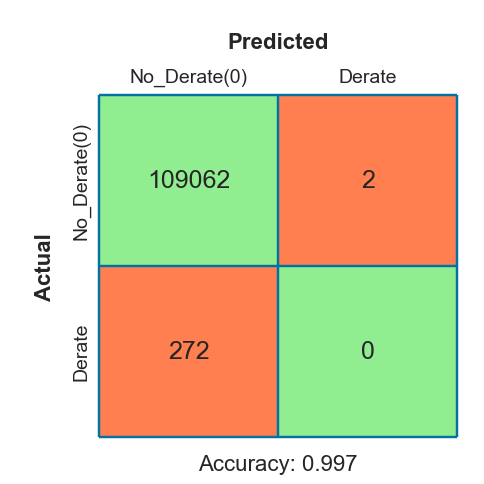

In [48]:
##step7 plotting matrix
plot_confusion_matrix(y_test1['target'], logReg_scaler.predict(X_test1_short), labels = ['No_Derate(0)', 'Derate'], metric = 'accuracy');

### using the fixed train test split improved slightly and False Negative reduced reduced from 382 to 272.
#### using OneHotEncoder on spn_fmi

In [49]:
?OneHotEncoder
#Do get_dummies then split then join
#, remainder='passthrough'

In [50]:
#from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
#step1
logReg_scaler_ohe = Pipeline(
    steps = [
        ('ct', ColumnTransformer(
            transformers = [
                ('ohe', OneHotEncoder(sparse=False, 
                                     handle_unknown="ignore"), ['spn_fmi'])])),
                                                                      
        ('impute', SimpleImputer()), #fills average of the column if there are NaN missing values
        ('scaler', StandardScaler()),
        ('log_reg', LogisticRegression(C = 0.01)) #started from 0.01, 0,001, 
    ]
).fit(X_train1_short, y_train1['target'])

In [51]:
X_train1_short.shape

(437338, 27)

In [52]:
X_test1_short.shape

(109336, 27)

In [53]:
# logReg_scaler_ohe['ct'].transform(X_test1_short).shape #(109336, 983)

logReg_scaler_ohe['ct'].transform(X_train1_short.head(5)).shape

(5, 953)

In [54]:
logReg_scaler_ohe 

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['spn_fmi'])])),
                ('impute', SimpleImputer()), ('scaler', StandardScaler()),
                ('log_reg', LogisticRegression(C=0.01))])

In [55]:
ohe = logReg_scaler_ohe.predict(X_train1_short.head(5))

In [56]:
##valueerror "X has 983 features, but SimpleImputer is expecting 979 features as input."

In [ ]:
confusion_matrix(y_test1['target'], logReg_scaler_ohe.predict(X_test1_short))

In [ ]:
##step7 plotting matrix
plot_confusion_matrix(y_test1['target'], logReg_scaler_ohe.predict(X_test1_short), labels = ['No_Derate(0)', 'Derate'], metric = 'accuracy');

In [ ]:
#step5
#extracting the features
pd.DataFrame({'feature': logReg_scaler_ohe['ct'].get_feature_names_out(),
                             'coefficient': logReg_scaler_ohe['log_reg'].coef_[0],
             "ex_coefficient": np.exp(logReg_scaler_ohe['log_reg'].coef_[0])}).sort_values(by='coefficient')
#every drop in the x-feature affects the predicted probability by the ex_coefficient

In [58]:
X_train_derate.shape #
(139945, 460)

(139945, 460)

In [59]:
(np.datetime64(X_train_derate['EventTimeStamp'].max())-np.datetime64(X_train_derate['EventTimeStamp'].min())) #the entire data spans over 1840 days

numpy.timedelta64(159042545000000,'us')

In [81]:
(np.datetime64(X_train_derate['EventTimeStamp'].max())-np.datetime64(X_train_derate['EventTimeStamp'].min()))/

numpy.timedelta64(5042566,'us')

In [72]:
(np.datetime64(X_train_derate.['EventTimeStamp'].max()))
#      np.datetime64(X_train_derate.groupby('EquipmentID_x')['EventTimeStamp'].min()))

numpy.datetime64('2020-03-06T12:20:36.000000')

## dearte trucks mean delta time in observations = Timedelta('997 days 10:54:11.164021152')

In [82]:
((df_derate.groupby('EquipmentID_x')['EventTimeStamp'].max())-
 (df_derate.groupby('EquipmentID_x')['EventTimeStamp'].min())).mean()

(((df_derate.groupby('EquipmentID_x')['EventTimeStamp'].max())
 -
 (df_derate.groupby('EquipmentID_x')['EventTimeStamp'].min()))).to_frame().sort_values('EventTimeStamp',
                                                                                           ascending=False).head(20).plot()

Timedelta('997 days 10:54:11.164021152')

## Nodearte trucks mean delta in observations = timeTimedelta('776 days 15:51:34.592028136')

In [73]:
((df_no.groupby('EquipmentID_x')['EventTimeStamp'].max())-
 (df_no.groupby('EquipmentID_x')['EventTimeStamp'].min())).mean()

((df_no.groupby('EquipmentID_x')['EventTimeStamp'].max())-
 (df_no.groupby('EquipmentID_x')['EventTimeStamp'].min())).to_frame().sort_values('EventTimeStamp',
                                                                                           ascending=False).tail(50)

,EventTimeStamp
EquipmentID_x,
2351,70 days 15:56:58
2325,67 days 07:42:27
2353,64 days 16:46:54
2331,62 days 21:01:52
2289,62 days 00:20:10
2366,61 days 08:12:51
2186,56 days 09:54:57
2341,54 days 17:54:36
2334,53 days 20:10:40


In [86]:
df_derate.info()
df_derate[['AcceleratorPedal', 'BarometricPressure', 'CruiseControlSetSpeed', 'DistanceLtd', 
 'EngineCoolantTemperature', 'EngineLoad', 'EngineOilPressure', 'EngineOilTemperature', 'EngineRpm', 
 'EngineTimeLtd', 'FuelLevel', 'FuelLtd', 'FuelRate', 'FuelTemperature', 'IntakeManifoldTemperature',
 'LampStatus', 'ServiceDistance', 'Speed', 'SwitchedBatteryVoltage', 'Throttle', 'TurboBoostPressure']].apply(pd.to_numeric, errors ='ignore')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174932 entries, 444126 to 70148
Columns: 461 entries, RecordID to target
dtypes: bool(1), datetime64[ns](2), float64(419), int32(1), int64(6), object(32)
memory usage: 614.8+ MB


,AcceleratorPedal,BarometricPressure,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,...,FuelLtd,FuelRate,FuelTemperature,IntakeManifoldTemperature,LampStatus,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
444126,0.000000,14.64500,66.486720,443434.900000,186.800000,12.000000,22.620000,203.787500,601.000000,10755.850000,...,62063.921467,0.713267,32.0,143.600000,1279.0,NaN,0.000000,NaN,100.0,0.580000
444127,0.000000,14.64500,66.486720,443434.900000,186.800000,12.000000,22.620000,203.787500,601.000000,10755.850000,...,62063.921467,0.713267,32.0,143.600000,1279.0,NaN,0.000000,NaN,100.0,0.580000
444128,0.000000,14.64500,66.486720,443434.300000,185.000000,17.000000,22.040000,208.793700,599.625000,10755.700000,...,62063.657295,0.752893,32.0,141.800000,1279.0,NaN,0.000000,NaN,100.0,0.580000
444129,0.000000,14.64500,66.486720,443434.300000,185.000000,17.000000,22.040000,208.793700,599.625000,10755.700000,...,62063.657295,0.752893,32.0,141.800000,1279.0,NaN,0.000000,NaN,100.0,0.580000
444130,0.000000,14.64500,66.486720,443424.000000,185.000000,12.000000,24.940000,193.831300,600.625000,10755.300000,...,62061.940176,0.726475,32.0,136.400000,1279.0,NaN,0.000000,NaN,100.0,0.290000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157880,37.200000,14.13750,66.486720,268575.900000,183.200000,26.000000,33.640000,217.287500,1035.500000,5004.750000,...,39450.133385,2.166218,NaN,60.800000,17407.0,NaN,36.389050,3276.75,NaN,1.160000
36118,57.600000,14.42750,64.622600,470383.500000,190.400000,46.000000,35.960000,211.550000,1321.875000,9480.050000,...,70350.338308,6.696783,NaN,114.800000,1023.0,NaN,62.205080,3276.75,NaN,9.570000
126238,0.000000,14.13750,64.622600,257885.900000,181.400000,80.000000,34.220000,218.975000,1382.375000,5085.350000,...,37724.957800,13.723780,NaN,78.800000,1023.0,NaN,64.826490,3276.75,NaN,17.690000
36119,48.000000,14.42750,64.622600,470381.400000,181.400000,30.000000,38.280000,196.531300,1514.500000,9480.000000,...,70349.809964,4.583399,NaN,111.200000,1023.0,NaN,13.602200,3276.75,NaN,6.670000


In [94]:
df_derate_nu = df_derate.apply(pd.to_numeric, errors ='ignore')
df_derate_nu.info()
df_derate_nu.columns.to_series().groupby(df_derate_nu.dtypes).groups

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174932 entries, 444126 to 70148
Columns: 461 entries, RecordID to target
dtypes: bool(1), float64(442), int32(1), int64(10), object(7)
memory usage: 614.8+ MB


{bool: ['active'], int32: ['target'], int64: ['RecordID', 'spn', 'fmi', 'ecuSource', 'spn', 'fmi', 'EquipmentID_x', 'LocationTimeStamp', 'EquipmentID_y', 'EventTimeStamp'], float64: ['AcceleratorPedal', 'BarometricPressure', 'CruiseControlSetSpeed', 'DistanceLtd', 'EngineCoolantTemperature', 'EngineLoad', 'EngineOilPressure', 'EngineOilTemperature', 'EngineRpm', 'EngineTimeLtd', 'FuelLevel', 'FuelLtd', 'FuelRate', 'FuelTemperature', 'IntakeManifoldTemperature', 'LampStatus', 'ServiceDistance', 'Speed', 'SwitchedBatteryVoltage', 'Throttle', 'TurboBoostPressure', 'activeTransitionCount', 'MCTNumber', 'Latitude', 'Longitude', 'spn_0', 'spn_100', 'spn_101', 'spn_102', 'spn_1023', 'spn_1024', 'spn_1028', 'spn_103', 'spn_1043', 'spn_1045', 'spn_105', 'spn_1056', 'spn_1059', 'spn_1067', 'spn_1068', 'spn_107', 'spn_1071', 'spn_1072', 'spn_1075', 'spn_1078', 'spn_108', 'spn_1081', 'spn_110', 'spn_111', 'spn_1127', 'spn_114863', 'spn_116', 'spn_1172', 'spn_1176', 'spn_118', 'spn_1209', 'spn_1213

In [90]:
df_no_nu = df_no.apply(pd.to_numeric, errors ='ignore')

In [95]:
df_no_nu.info()
df_no_nu.columns.to_series().groupby(df_no_nu.dtypes).groups

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371742 entries, 536775 to 52370
Columns: 461 entries, RecordID to target
dtypes: bool(1), float64(442), int32(1), int64(8), object(9)
memory usage: 1.3+ GB


{bool: ['active'], int32: ['target'], int64: ['RecordID', 'spn', 'fmi', 'ecuSource', 'spn', 'fmi', 'LocationTimeStamp', 'EventTimeStamp'], float64: ['AcceleratorPedal', 'BarometricPressure', 'CruiseControlSetSpeed', 'DistanceLtd', 'EngineCoolantTemperature', 'EngineLoad', 'EngineOilPressure', 'EngineOilTemperature', 'EngineRpm', 'EngineTimeLtd', 'FuelLevel', 'FuelLtd', 'FuelRate', 'FuelTemperature', 'IntakeManifoldTemperature', 'LampStatus', 'ServiceDistance', 'Speed', 'SwitchedBatteryVoltage', 'Throttle', 'TurboBoostPressure', 'activeTransitionCount', 'MCTNumber', 'Latitude', 'Longitude', 'spn_0', 'spn_100', 'spn_101', 'spn_102', 'spn_1023', 'spn_1024', 'spn_1028', 'spn_103', 'spn_1043', 'spn_1045', 'spn_105', 'spn_1056', 'spn_1059', 'spn_1067', 'spn_1068', 'spn_107', 'spn_1071', 'spn_1072', 'spn_1075', 'spn_1078', 'spn_108', 'spn_1081', 'spn_110', 'spn_111', 'spn_1127', 'spn_114863', 'spn_116', 'spn_1172', 'spn_1176', 'spn_118', 'spn_1209', 'spn_1213', 'spn_1231', 'spn_1235', 'spn_12

In [18]:
## notice that the columns from diagnostics can not be used for mean etc as they are object so going to change them as int.


In [ ]:
X_train1_short[chosen_cl] = X_train1[chosen_cl].astype(str).astype(int)

In [15]:
derate_feature.info()
derate_feature.columns.to_series().groupby(derate_feature.dtypes).groups

<class 'pandas.core.frame.DataFrame'>
Int64Index: 546674 entries, 536775 to 70148
Columns: 461 entries, RecordID to target
dtypes: bool(1), datetime64[ns](2), float64(419), int32(1), int64(6), object(32)
memory usage: 1.9+ GB


{bool: ['active'], int64: ['RecordID', 'spn', 'fmi', 'ecuSource', 'spn', 'fmi'], float64: ['Latitude', 'Longitude', 'spn_0', 'spn_100', 'spn_101', 'spn_102', 'spn_1023', 'spn_1024', 'spn_1028', 'spn_103', 'spn_1043', 'spn_1045', 'spn_105', 'spn_1056', 'spn_1059', 'spn_1067', 'spn_1068', 'spn_107', 'spn_1071', 'spn_1072', 'spn_1075', 'spn_1078', 'spn_108', 'spn_1081', 'spn_110', 'spn_111', 'spn_1127', 'spn_114863', 'spn_116', 'spn_1172', 'spn_1176', 'spn_118', 'spn_1209', 'spn_1213', 'spn_1231', 'spn_1235', 'spn_1236', 'spn_1239', 'spn_1247', 'spn_125', 'spn_127', 'spn_1279', 'spn_1321', 'spn_1322', 'spn_1323', 'spn_1324', 'spn_1325', 'spn_1326', 'spn_1327', 'spn_1328', 'spn_1347', 'spn_1349', 'spn_13600', 'spn_139296', 'spn_1464', 'spn_1481', 'spn_1482', 'spn_1483', 'spn_1487', 'spn_153', 'spn_153931', 'spn_1569', 'spn_157', 'spn_158', 'spn_16', 'spn_160', 'spn_1612', 'spn_1659', 'spn_1668', 'spn_167', 'spn_1675', 'spn_168', 'spn_17096', 'spn_171', 'spn_173', 'spn_174', 'spn_175', 'spn

In [17]:
derate_feature = pd.get_dummies(derate_feature, columns=['spn_fmi'], prefix='spn_fmi') #got the spn_fmi also as dummies call

In [19]:
derate_feature.info()
derate_feature.columns.to_series().groupby(derate_feature.dtypes).groups

<class 'pandas.core.frame.DataFrame'>
Int64Index: 546674 entries, 536775 to 70148
Columns: 1443 entries, RecordID to spn_fmi_98_5
dtypes: bool(1), datetime64[ns](2), float64(419), int32(1), int64(6), object(31), uint8(983)
memory usage: 2.4+ GB


{bool: ['active'], int64: ['RecordID', 'spn', 'fmi', 'ecuSource', 'spn', 'fmi'], float64: ['Latitude', 'Longitude', 'spn_0', 'spn_100', 'spn_101', 'spn_102', 'spn_1023', 'spn_1024', 'spn_1028', 'spn_103', 'spn_1043', 'spn_1045', 'spn_105', 'spn_1056', 'spn_1059', 'spn_1067', 'spn_1068', 'spn_107', 'spn_1071', 'spn_1072', 'spn_1075', 'spn_1078', 'spn_108', 'spn_1081', 'spn_110', 'spn_111', 'spn_1127', 'spn_114863', 'spn_116', 'spn_1172', 'spn_1176', 'spn_118', 'spn_1209', 'spn_1213', 'spn_1231', 'spn_1235', 'spn_1236', 'spn_1239', 'spn_1247', 'spn_125', 'spn_127', 'spn_1279', 'spn_1321', 'spn_1322', 'spn_1323', 'spn_1324', 'spn_1325', 'spn_1326', 'spn_1327', 'spn_1328', 'spn_1347', 'spn_1349', 'spn_13600', 'spn_139296', 'spn_1464', 'spn_1481', 'spn_1482', 'spn_1483', 'spn_1487', 'spn_153', 'spn_153931', 'spn_1569', 'spn_157', 'spn_158', 'spn_16', 'spn_160', 'spn_1612', 'spn_1659', 'spn_1668', 'spn_167', 'spn_1675', 'spn_168', 'spn_17096', 'spn_171', 'spn_173', 'spn_174', 'spn_175', 'spn

In [33]:
derate_feature.loc[derate_feature['target']== 1]['EquipmentID_x'].nunique() #189
derate_feature.loc[derate_feature['target']== 0]['EquipmentID_x'].nunique() #1042

1042

In [24]:
df_all_derate = derate_feature.apply(pd.to_numeric, errors ='ignore')

In [26]:
df_all_derate.columns.to_series().groupby(df_all_derate.dtypes).groups

{bool: ['active'], uint8: ['spn_fmi_0_0', 'spn_fmi_100_1', 'spn_fmi_100_18', 'spn_fmi_100_2', 'spn_fmi_100_3', 'spn_fmi_100_4', 'spn_fmi_101_0', 'spn_fmi_101_15', 'spn_fmi_101_16', 'spn_fmi_101_2', 'spn_fmi_101_3', 'spn_fmi_101_4', 'spn_fmi_1023_5', 'spn_fmi_1024_0', 'spn_fmi_1028_9', 'spn_fmi_102_10', 'spn_fmi_102_14', 'spn_fmi_102_15', 'spn_fmi_102_16', 'spn_fmi_102_17', 'spn_fmi_102_18', 'spn_fmi_102_2', 'spn_fmi_102_20', 'spn_fmi_102_3', 'spn_fmi_102_31', 'spn_fmi_102_4', 'spn_fmi_102_5', 'spn_fmi_103_1', 'spn_fmi_103_10', 'spn_fmi_103_16', 'spn_fmi_103_18', 'spn_fmi_103_4', 'spn_fmi_103_7', 'spn_fmi_103_9', 'spn_fmi_1043_2', 'spn_fmi_1045_2', 'spn_fmi_1045_7', 'spn_fmi_1056_2', 'spn_fmi_1056_4', 'spn_fmi_1056_5', 'spn_fmi_1059_2', 'spn_fmi_105_0', 'spn_fmi_105_17', 'spn_fmi_105_18', 'spn_fmi_105_2', 'spn_fmi_105_3', 'spn_fmi_105_5', 'spn_fmi_1067_11', 'spn_fmi_1067_2', 'spn_fmi_1067_7', 'spn_fmi_1068_2', 'spn_fmi_1071_5', 'spn_fmi_1072_1', 'spn_fmi_1072_3', 'spn_fmi_1072_5', 'spn_

In [28]:
df_all_derate.columns.to_list()

['RecordID',
 'spn',
 'fmi',
 'AcceleratorPedal',
 'BarometricPressure',
 'CruiseControlSetSpeed',
 'DistanceLtd',
 'EngineCoolantTemperature',
 'EngineLoad',
 'EngineOilPressure',
 'EngineOilTemperature',
 'EngineRpm',
 'EngineTimeLtd',
 'FuelLevel',
 'FuelLtd',
 'FuelRate',
 'FuelTemperature',
 'IntakeManifoldTemperature',
 'LampStatus',
 'ServiceDistance',
 'Speed',
 'SwitchedBatteryVoltage',
 'Throttle',
 'TurboBoostPressure',
 'eventDescription',
 'ecuSoftwareVersion',
 'ecuSerialNumber',
 'ecuModel',
 'ecuMake',
 'ecuSource',
 'spn',
 'fmi',
 'active',
 'activeTransitionCount',
 'EquipmentID_x',
 'MCTNumber',
 'Latitude',
 'Longitude',
 'LocationTimeStamp',
 'SPN_FMI',
 'EquipmentID_y',
 'EventTimeStamp',
 'spn_0',
 'spn_100',
 'spn_101',
 'spn_102',
 'spn_1023',
 'spn_1024',
 'spn_1028',
 'spn_103',
 'spn_1043',
 'spn_1045',
 'spn_105',
 'spn_1056',
 'spn_1059',
 'spn_1067',
 'spn_1068',
 'spn_107',
 'spn_1071',
 'spn_1072',
 'spn_1075',
 'spn_1078',
 'spn_108',
 'spn_1081',
 's

In [34]:
#Droping the object column and the column with sp_5246, and spn_fmi_5246_0, to eliminate the bias
df_all_derate = df_all_derate.drop(columns=['eventDescription', 'ecuSoftwareVersion', 'ecuSerialNumber', 'ecuModel', 
                            'ecuMake', 'EquipmentID_y', 'SPN_FMI',
                           'ecuSource', 'spn', 'fmi', 'LocationTimeStamp', 'EventTimeStamp',
                           'active',
                           'spn_5246',
                           'spn_fmi_5246_0', 'spn_fmi_5246_16',
                           'spn_fmi_5246_15', 'spn_fmi_5246_19', 'spn_fmi_5246_14']) #546674 rows × 1428 columns

In [35]:
df_all_derate.columns.to_list()

['RecordID',
 'AcceleratorPedal',
 'BarometricPressure',
 'CruiseControlSetSpeed',
 'DistanceLtd',
 'EngineCoolantTemperature',
 'EngineLoad',
 'EngineOilPressure',
 'EngineOilTemperature',
 'EngineRpm',
 'EngineTimeLtd',
 'FuelLevel',
 'FuelLtd',
 'FuelRate',
 'FuelTemperature',
 'IntakeManifoldTemperature',
 'LampStatus',
 'ServiceDistance',
 'Speed',
 'SwitchedBatteryVoltage',
 'Throttle',
 'TurboBoostPressure',
 'activeTransitionCount',
 'EquipmentID_x',
 'MCTNumber',
 'Latitude',
 'Longitude',
 'spn_0',
 'spn_100',
 'spn_101',
 'spn_102',
 'spn_1023',
 'spn_1024',
 'spn_1028',
 'spn_103',
 'spn_1043',
 'spn_1045',
 'spn_105',
 'spn_1056',
 'spn_1059',
 'spn_1067',
 'spn_1068',
 'spn_107',
 'spn_1071',
 'spn_1072',
 'spn_1075',
 'spn_1078',
 'spn_108',
 'spn_1081',
 'spn_110',
 'spn_111',
 'spn_1127',
 'spn_114863',
 'spn_116',
 'spn_1172',
 'spn_1176',
 'spn_118',
 'spn_1209',
 'spn_1213',
 'spn_1231',
 'spn_1235',
 'spn_1236',
 'spn_1239',
 'spn_1247',
 'spn_125',
 'spn_127',
 's

In [38]:
df_only_derate = df_all_derate[(df_all_derate['EquipmentID_x'].isin(derate_trucks))]
df_only_derate.shape #(174932, 1422)

(174932, 1422)

In [39]:
df_only_no = df_all_derate[(df_all_derate['EquipmentID_x'].isin(no_derate))] #371742 rows × 1422 columns
df_only_no.shape

(371742, 1422)

In [40]:
##Making the 80/20 split in the train/test among all the trucks with noderate

X1_no = df_only_no.drop(columns=['target', 'EquipmentID_x'])
y1_no= df_only_no[['target']]

X1_train_noderate, X1_test_noderate, y1_train_noderate, y1_test_noderate = train_test_split(X1_no, y1_no, train_size = 0.8,
                                                                                test_size = 0.2, 
                                                                                random_state = 321)

print(X1_train_noderate.shape)
print(X1_test_noderate.shape)
print(y1_train_noderate.shape)
print(y1_test_noderate.shape)

(297393, 1420)
(74349, 1420)
(297393, 1)
(74349, 1)


In [42]:
##Making the 80/20 split in the train/test among all the trucks with noderate

X1_yes = df_only_derate.drop(columns=['target', 'EquipmentID_x'])
y1_yes = df_only_derate[['target']]

X1_train_derate, X1_test_derate, y1_train_derate, y1_test_derate = train_test_split(X1_yes, y1_yes, train_size = 0.8,
                                                                                test_size = 0.2, 
                                                                                random_state = 321)

print(X1_train_derate.shape)
print(X1_test_derate.shape)
print(y1_train_derate.shape)
print(y1_test_derate.shape)

(139945, 1420)
(34987, 1420)
(139945, 1)
(34987, 1)


In [43]:
X1_train = pd.concat([X1_train_derate, X1_train_noderate], axis=0) #437338 rows × 460 columns

X1_test = pd.concat([X1_test_derate, X1_test_noderate], axis=0) #109336 rows × 460 columns

y1_train = pd.concat([y1_train_derate, y1_train_noderate], axis=0) #437338 rows × 1 columns

y1_test = pd.concat([y1_test_derate, y1_test_noderate], axis=0) #109336 rows × 1 columns

print(X1_train.shape)
print(X1_test.shape)
print(y1_train.shape)
print(y1_test.shape)

(437338, 1420)
(109336, 1420)
(437338, 1)
(109336, 1)


In [52]:
#from sklearn.impute import SimpleImputer
#step1
logReg_scaler = Pipeline(
    steps = [
        ('impute', SimpleImputer()), #fills average of the column if there are NaN missing values
        ('scaler', StandardScaler()),
        ('log_reg', LogisticRegression(C = 0.01)) #started from 0.01, 0,001, 
    ]
).fit(X1_train, y1_train)

AttributeError: 'Pipeline' object has no attribute 'partial_fit'

In [48]:
# #step2
logreg1 = logReg_scaler.predict(X1_test)

NameError: name 'logReg_scaler' is not defined

In [46]:
# #step3
# accuracy_score(y_test1['target'], logreg1) 

# #step4 ROC_AUC 
# roc_auc_score(y_test1['target'], logReg_scaler.predict_proba(X_test1_short)[:,1] )

# #step5
# #extracting the features
# pd.DataFrame({'feature': logReg_scaler['impute'].get_feature_names_out(),
#                              'coefficient': logReg_scaler['log_reg'].coef_[0],
#              "ex_coefficient": np.exp(logReg_scaler['log_reg'].coef_[0])}).sort_values(by='coefficient')
# #every drop in the x-feature affects the predicted probability by the ex_coefficient

# #step6 confusion matrix
# confusion_matrix(y_test1['target'], logReg_scaler.predict(X_test1_short))

# ##step7 plotting matrix
# plot_confusion_matrix(y_test1['target'], logReg_scaler.predict(X_test1_short), labels = ['No_Derate(0)', 'Derate'], metric = 'accuracy');

MemoryError: Unable to allocate 4.63 GiB for an array with shape (1420, 437338) and data type float64